<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº1: Síntesis de señales
#### María Victoria Poric

# Introducción teórica

Para el análisis y procesamiento de señales resulta fundamental contar con herramientas que permitan cuantificar y comparar su comportamiento. Dos conceptos centrales en este contexto son la energía y la potencia de una señal. La energía se define como la integral (o suma discreta) del cuadrado de la amplitud de la señal en el tiempo, y representa la magnitud total acumulada. La potencia, en cambio, corresponde al valor promedio de esa energía en el tiempo, lo que permite caracterizar señales periódicas o de duración infinita. Como en este caso estaremos trabajando en ventanas de tiempo, es decir, las señales tienen una duración finita, se trabajará con energía en lugar de potencia. 

Otro aspecto relevante en el estudio de señales es la ortogonalidad, que surge al considerar el producto interno entre dos señales. Cuando el producto interno es nulo, se dice que las señales son ortogonales, lo cual tiene aplicaciones directas en el diseño de sistemas de comunicación y en el análisis de Fourier. En este trabajo tomaremos como ortogonales aquellas señales que su procuto interno también sea aproximadamente cero, no necesariamente cero exacto. La correlación es otra herramienta asociada, que mide la similitud entre señales en función de un posible desplazamiento temporal.

El uso de identidades trigonométricas también se vincula con el análisis de señales senoidales, dado que permiten expresar productos de senos en términos de sumas de cosenos, simplificando cálculos y demostrando relaciones de ortogonalidad entre funciones sinusoidales de distinta frecuencia.

En este trabajo se implementan y simulan diferentes señales (senoidales, moduladas, cuadradas y pulsos), con el objetivo de calcular su energía, estudiar su ortogonalidad y analizar correlaciones. Además, se extiende el análisis a un caso práctico mediante la lectura de un archivo de audio en formato WAV, mostrando la aplicabilidad de las herramientas teóricas a señales reales.

# Análisis y desarrollo
Para realizar este trabajo se implemento el siguiente código en Spyder:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def f_senoidales(amp_max, offset, frec, fase, N, frec_ADC):
    Ts = 1 / frec_ADC #[s]
    n = np.arange(N) #índices de 0 a N-1
    tt = n * Ts                 
    xx = amp_max * np.sin(2*np.pi*frec*tt + fase) + offset
    
    return tt, xx

def energia(x, frec_ADC):
    Ts = 1 / frec_ADC
    return np.sum(x**2) * Ts   # Energía total

def producto_interno(x, y):
    return np.dot(x, y) / len(x) #np.dot calcula el producto escalar

def ortogonalidad(x, y, tol = 1e-6):
    return abs(producto_interno(x, y)) < tol

def xcorr(x, y):
    x0 = x - np.mean(x)
    y0 = y - np.mean(y)
    c = np.correlate(x0, y0, mode = 'full') / len(x0)
    #np.correlate calcula la correlacion cruzada o la autocorrelacion de ser
    #el mismo array, sirve para ver similitud o desplazamiento en señales
    #devuelve un array de cuanto se parecen las dos secuencias en distintos desplazamientos
    return c

def recorta_energia(x, frec_ADC, ratio = 0.75, iter = 40):
    # recorta x a ±c tal que la energía sea ratio * E_original
    E0 = energia(x, frec_ADC)
    obj = ratio * E0
    a, b = 0.0, np.max(np.abs(x))
    for _ in range(iter):
        c = (a + b) / 2
        Ec = energia(np.clip(x, -c, c), frec_ADC)
        if Ec < obj:
            a = c
        else:
            b = c
    return np.clip(x, -b, b)
#clip es cortar los picos de la señal

Para comenzar explicaré un poco el código desarrollado. Para trabajar con esta tarea se decidió definir todas las funciones que iba a utilizar durante el trabajo al principio. La función **f_senoidales** es una función hecha para el la tarea semanal 0 que toma como parámetros la cantidad de muestras(N), la frecuencia de muestreo, la frecuencia de la señal, la amplitud, el offset y la fase, y devuelve los valores de x y tiempo. Luego la función **energía** calcula la energía, ya que al ser señales senoidales en una ventana de tiempo finita, se calcula la energía. Después, la función **producto_interno** toma dos vectores x e y, durante nuestra práctica serán los vectores x de las señales, y calcula el producto escalar y luego lo normaliza al dividirlo por la longitud de x. A continuación, para la función **ortogonalidad** se usa la función del producto interno. Para decir que dos señales son ortogonales el valor del producto interno debe ser cero, pero en nuestro caso los valores no serán exactamente cero(por redondeo y errores numéricos), con lo cual si el valor numérico es menor que el valor de la tolerancia se los considera ortogonales, la función devuelve True o False, dependiendo si es o no ortogonal. Luego, tenemos la función **xcorr** que toma dos vectores y se fija la correlación entre ambas señales. En la librería numpy, np.correlate calcula la correlacion cruzada o la autocorrelacion de ser el mismo array, sirve para ver similitud o desplazamiento en señales, devuelve un array de cuanto se parecen las dos secuencias en distintos desplazamientos. Por último, tenemos la función **recorta_energia**, E0 es la energía original y obj es la energía objetivo, en este caso como se solicita es un 75% de la energía original, el ratio es 0.75. En a=0 el recorte es extremo, la energía es 0, en b=max|x| es casi sin recorte, la energía queda casi como la original. Luego se crea un ciclo for donde se iterará según el método de bisección(toma el punto medio c), tomo 40 porque es más que suficiente, en Ec se recorta con + o - c y se calcula la energía resultante. Si la energía resultante está por debajo de la deseada se está recortando demasiado, entonces se sube el umbral a=c. Si la energía resultante está por encima o es igual a la deseada, se puede bajar el umbral b=c. Al terminar, b quedó como el menor umbral del rango tal que la energía es ≥ objetivo (nos quedamos del “lado seguro” para no terminar por debajo de la potencia deseada por efecto de redondeos). Se devuelve la señal recortada con ese umbral.  

In [6]:
frec_ADC = 100000
N = 800
Ts = 1 / frec_ADC
t, _ = f_senoidales(0, 0, 1, 0, N, frec_ADC)

amp_max = 1

#2.1 Señal senoidal de 2000 Hz
f1 = 2000

t, x1 = f_senoidales(amp_max, 0, f1, 0, N, frec_ADC)

#2.2 Misma señal amplificada y desfasada pi/2
fase = np.pi / 2
_, x2 = f_senoidales(3*amp_max, 0, f1, fase, N, frec_ADC)

#2.3 Misma señal modulada en amplitud por seno de la mitad de la frecuencia
m = 0.5
f_mod = f1 / 2
mod = 1 + m*np.sin(2*np.pi*f_mod*t) #envolvente AM
x3 = mod * (amp_max*np.sin(2*np.pi*f1*t)) #AM aca esta la multiplicacion de los senos


#2.4 Señal anterior recortada a 75% de su potencia
x4 = recorta_energia(x3, frec_ADC, ratio = 0.75)

#2.5 Señal cuadrada de 4 kHz(amplitud amp_max, valores + o - amp_max)
x5 = amp_max * np.sign(np.sin(2*np.pi*4000*t)) 
#np.sign devuelve el signo de un numero(+ o - o 0)
#sin devuelve un seno, sign me da solo el signo y al multiplicar por la amplitud tengo la
#señal cuadrada


#2.6 Pulso rectangular de 10 ms (amplitud amp_max)
x6 = np.zeros_like(t) #np.zeros_like crea un array del mismo tamaño de lo que se lo este
                    #igualando nada mas que lleno de ceros, sirve para ir llenando el array
t0, ancho = 0.002, 0.001 #pulso entre 20 ms y 30 ms
mask = (t >= t0) & (t < t0 + ancho) #crea una mascara para el intervalo 20ms<=t<30ms
x6[mask] = amp_max #en el intervalo de la mascara le asigno la amplitud y en el resto que sea cero

Luego, se le da un valor a la frecuencia de muestreo lo suficientemente alto para que cumpla Nyquist, y también valores de N, y se obtiene el valor del eje temporal t que se usará para el resto de las otras señales, se usa el _ para omitir los valores en Python, se podría decir que no los guarda. Luego se le da una amplitud de 1V y f1=2000 Hz y se crea la señal pedida en el punto 1. A continuación, se pide la misma señal amplificada y desfasada, en este caso solo se queda con los valores de x. Para el item 3 se solicita la misma señal modulada en amplitud por otra señal sinusoidal de la mitad de la frecuencia. Modular señales significa multiplicar ambas señales es decir ambos senos. El 
\begin {equation}
m=0.5
\end {equation}
servirá para multiplicar por la mitad de la amplitud original y también se reduce la frecuencia a la mitad, luego *mod* será la señal modulada. El 1 delante representa la señal portadora. Luego *x3* será la modulación, es decir, la multiplicación entre la señal modulada y la señal original. 
Para el item 4, simplemente se usó la función de recortar potencia. Para la señal cuadrada de 4000 Hz, se hace la senoidal con la frecuencia pedida y con **np.sign** se guarda el signo de ella y multiplica por la amplitud, obteniendo así la señal de tipo cuadrada. Por último, para la señal 6, el pulso de 10 ms, se crea en principio un vector con **np.zeros_like** que crea un array del mismo tamaño que t pero lleno de ceros. Luego mediante mask se crea una máscara para el intervalo 
\begin {equation}
20 ms <= t < 30 ms
\end {equation}
y por último solo en en el intervalo de la máscara le asigno la amplitud de la señal, en el resto se mantiene cero, así se logra ver el pulso. 

Tiempo entre muestras Ts = 1.00e-05 s       | N = 800       | Ventana = 0.008 s



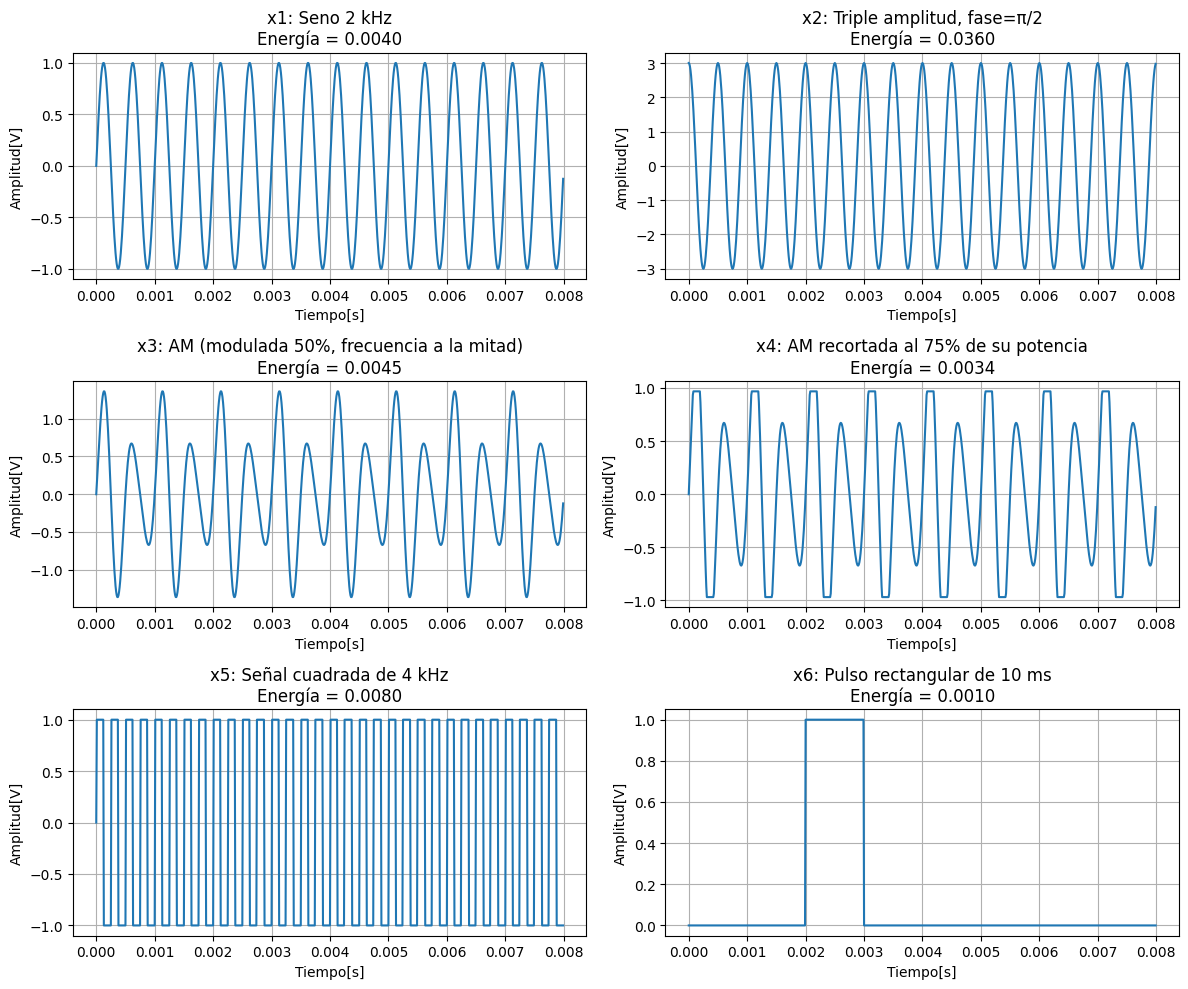

In [7]:
senales = {
    "x1: Seno 2 kHz":x1,
    "x2: Triple amplitud, fase=π/2":x2,
    "x3: AM (modulada 50%, frecuencia a la mitad)":x3,
    "x4: AM recortada al 75% de su potencia":x4,
    "x5: Señal cuadrada de 4 kHz":x5,
    "x6: Pulso rectangular de 10 ms":x6,
}

print(f"Tiempo entre muestras Ts = {Ts:.2e} s       | N = {N}       | Ventana = {N*Ts:.3f} s\n")

plt.figure(figsize=(12, 10))
for i, (nombre, x) in enumerate(senales.items(), 1):
    E = energia(x, frec_ADC)
    plt.subplot(3, 2, i)
    plt.plot(t, x)
    plt.title(f"{nombre}\nEnergía = {E :.4f}")
    plt.xlabel("Tiempo[s]")
    plt.ylabel("Amplitud[V]")
    plt.grid(True)
plt.tight_layout()
plt.show()

A continuación, para la facilidad del código, se crea un vector llamado *senales* donde se guardan todos los valores de las 6 señales como tuplas(nombre de la señal y el valor x), así cuando se quiera graficar o usar todos, se llama a ese vector en lugar de tener que llamar a cada uno. El tiempo de muestras, la cantidad de muestras y la ventana es la misma para las 6 señales por eso solo se lo imprime una vez. Luego, se grafican todas las señales, mediante un ciclo for recorre el vector de senales y se le pide al contador que arranque en 1 y no en cero, y así se grafica la señal y se calcula la potencia de cada una.  

In [9]:
#tiene que se aproximadamente cero
base = x1

for nombre, x in list(senales.items())[1: ]:
    pi = producto_interno(base, x)
    print(f"<x1, {nombre}> = {pi:.3e}  -> ortogonales : {ortogonalidad(base, x)}")

<x1, x2: Triple amplitud, fase=π/2> = 2.124e-15  -> ortogonales : True
<x1, x3: AM (modulada 50%, frecuencia a la mitad)> = 5.000e-01  -> ortogonales : False
<x1, x4: AM recortada al 75% de su potencia> = 4.413e-01  -> ortogonales : False
<x1, x5: Señal cuadrada de 4 kHz> = -1.954e-16  -> ortogonales : True
<x1, x6: Pulso rectangular de 10 ms> = 6.696e-18  -> ortogonales : True


Después se procede con el próximo punto que es verificar que sean ortogonales. Aquí se usaron las funciones *producto_interno* y *ortogonalidad*. En primer lugar se dejó asentado que la base para calcular todos los productos internos sería la primera señal(x1). Luego mediante un ciclo for, se fue recorriendo el vector senales y calculando el producto interno entre la primera señal y todas las demás señales e imprimiendolo. Asimismo se devuelve True o False si es o no ortogonal respectivamente.

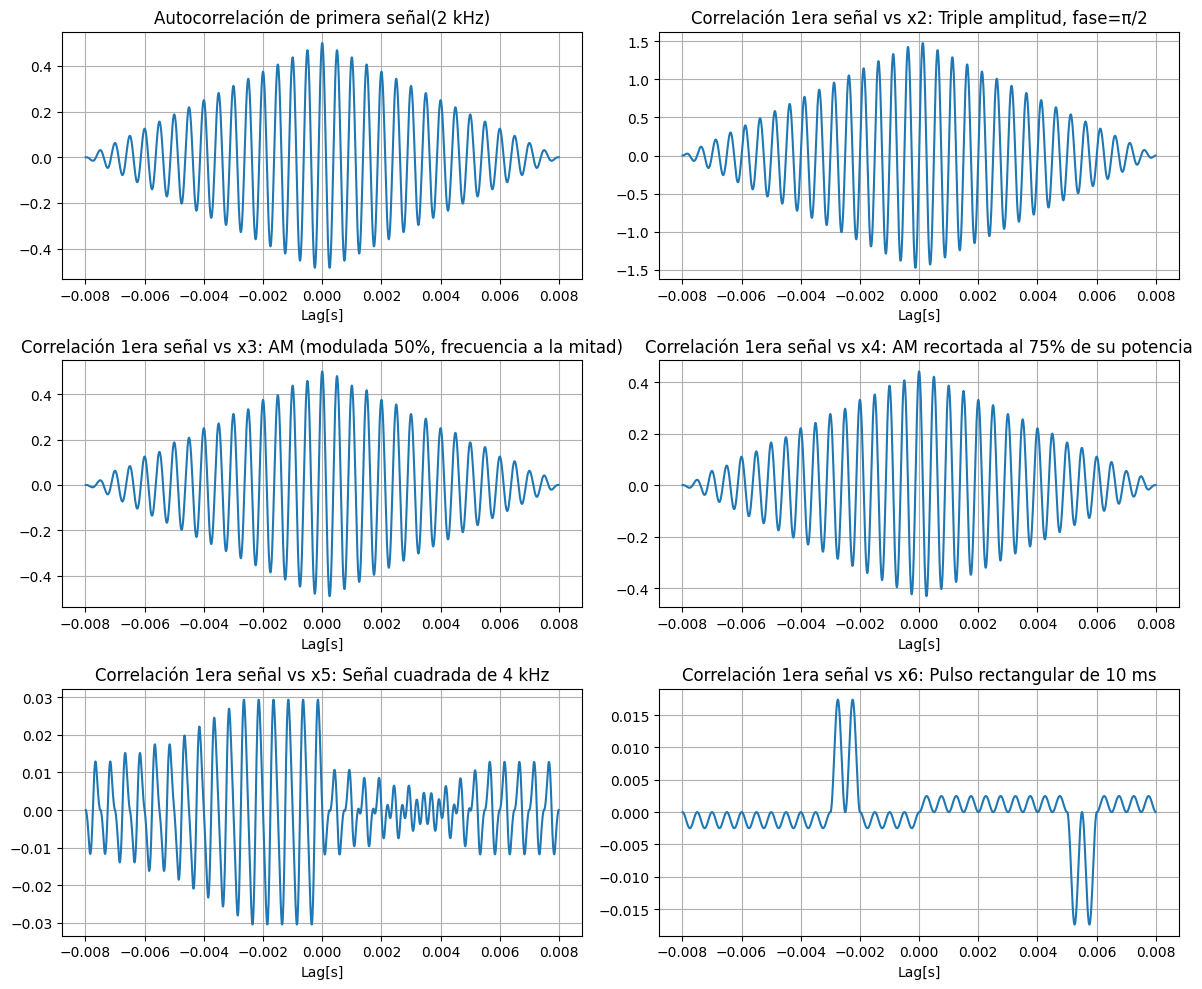

In [10]:
lags = np.arange(-N+1, N) * Ts #El vector lags representa los desplazamientos temporales que se usan en la correlación

plt.figure(figsize=(12,10))

#Autocorrelación de 1er señal
c_auto = xcorr(x1, x1)
plt.subplot(3, 2, 1)
plt.plot(lags, c_auto)
plt.title("Autocorrelación de primera señal(2 kHz)")
plt.xlabel("Lag[s]")
plt.grid(True)

#Correlaciones cruzadas
pos = 2
for nombre, x in list(senales.items())[1: ]:
    c = xcorr(x1, x)
    plt.subplot(3, 2, pos)
    plt.plot(lags, c)
    plt.title(f"Correlación 1era señal vs {nombre}")
    plt.xlabel("Lag[s]")
    plt.grid(True)
    pos += 1 
    
plt.tight_layout()
plt.show()

Luego para la correlación de señales, se procedió con el vector lags que representa el desplazamiento temporal que se usan en la correlación, es decir, cuanto se mueve una señal respecto de la otra. *c_auto* calcula la autocorrelación de la primera señal, mide cuánto se parece la señal consigo misma si se desplaza en el tiempo. A continuación, se inicializa en posición 2, ya que la primera señal ya se usó, y con un ciclo for se recorre la señales y se mide la similitud entre *x1* y x a distintos desplazamientos temporales. La autocorrelación de la primera señal (2 kHz): siempre es simétrica respecto de cero; el valor máximo está en lag = 0, porque la señal consigo misma está perfectamente alineada; luego se repiten los picos decrecientes por la naturaleza oscilatoria de la señal (senoidal). Correlación cruzada con la segunda señal (triple amplitud, misma frecuencia): la forma es muy parecida a la autocorrelación, porque ambas señales tienen la misma frecuencia y fase, la diferencia es que los valores son más grandes, ya que la segunda señal tiene amplitud mayor. Correlación cruzada con la tercera señal (mitad de frecuencia, modulada en amplitud): se ven oscilaciones más anchas (porque la frecuencia es menor); la correlación es más baja que en el caso anterior, ya que las señales no están en perfecta sintonía (una es de 2 kHz, la otra de 1 kHz modulada). Correlación con la señal de ruido: la correlación parece casi plana, sin estructura clara, con valores muy bajos; esto indica que el ruido es no correlacionado con la señal de referencia. 

Error máximo |lhs - rhs| = 3.6637359812630166e-15


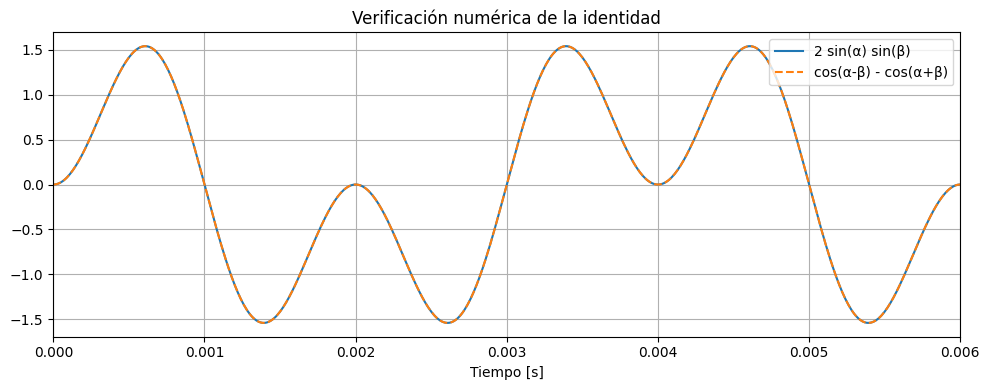

In [11]:
f0 = 500
alpha = 2*np.pi*f0*t
beta = np.pi*f0*t #(2pi f0 /2) t

lhs = 2*np.sin(alpha)*np.sin(beta)
rhs = np.cos(alpha - beta) - np.cos(alpha + beta)

print("Error máximo |lhs - rhs| =", np.max(np.abs(lhs-rhs)))

plt.figure(figsize=(10,4))
plt.plot(t, lhs, label="2 sin(α) sin(β)")
plt.plot(t, rhs, '--', label="cos(α-β) - cos(α+β)")
plt.xlim(0, 3/f0) #3 períodos de f0
plt.legend()
plt.grid(True)
plt.xlabel("Tiempo [s]")
plt.title("Verificación numérica de la identidad")
plt.tight_layout()
plt.show()

Por último para la identidad trigonométrica se establecieron los valores de alpha y beta y luego se usaron estos dentro de la ecuación. Para corroborar la identidad se graficó tanto el seno como el coseno. Al ser igual el gráfico se comprueba.

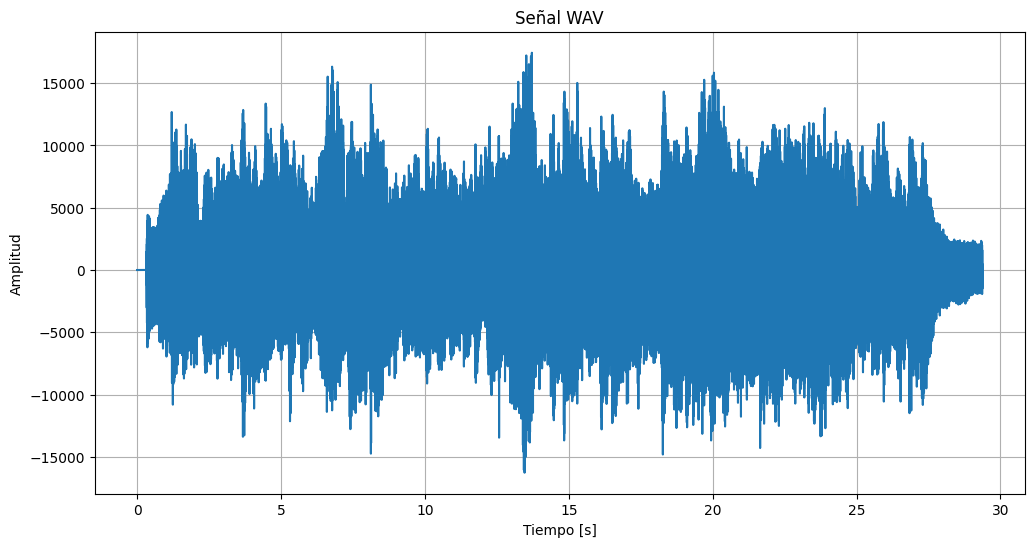

Energía de la señal: 341571076.80


In [4]:
# Leer archivo wav
fs, data = wavfile.read("sonido.wav.wav")   # fs = frecuencia de muestreo, data = señal

# Normalizar si es estéreo (dos canales)
if data.ndim > 1:
    data = data[:,0]  # tomar un canal

# Vector de tiempo
t = np.arange(len(data)) / fs

# Graficar señal
plt.figure(figsize=(12,6))
plt.plot(t, data)
plt.title("Señal WAV")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

# Calcular energía: sum(x^2)*Ts
E = energia(data.astype(float), fs)
print(f"Energía de la señal: {E:.2f}")

Para el punto Bonus se descargo una señal cualquiera. Luego se la graficó y se calculó su energia con la función de energía. 

# Conclusiones

Para concluir, para la ortogonalidad de señales el análisis numérico mostró que la ortogonalidad entre señales depende tanto de sus características (frecuencia, fase y forma de onda) como de la ventana de observación utilizada. Si la ventana no contiene un número entero de períodos, la ortogonalidad ideal no se cumple y aparecen pequeños errores numéricos. Aun así, el producto interno permitió identificar señales claramente no relacionadas, reforzando el concepto teórico de ortogonalidad aplicado a señales reales y simuladas. En el caso de la correlación se puede decir que la correlación es alta cuando las señales comparten frecuencia, fase y amplitud (autocorrelación o señales muy parecidas), disminuye si cambian parámetros como la frecuencia o la modulación, tiende a ser casi cero con señales no relacionadas, como el ruido. También quedo demostrada la identidad trigonométrica que es de gran uso diario. 

# Autoevaluación del aprendizaje

En esta práctica pude resolver la tarea pedida pero sin embargo me siguen quedando algunas dudas del procedimiento. Creo que la pude resolver más que nada por consultar en internet, usando chat GPT y otras páginas para entender bien las librerías y las funciones de numpy. Creo que recién ahora puedo decir que comprendo bien como trabajar con Spyder, Jupyter y Github ya que fue bastante complicado adaptarse y entender al principio. Usé IA más que nada para consultar conceptos y para ayuda con el código, fui dándole ideas y pedía que me lo corrija para que funcione correctamente. Tuve problemas con el bonus en un principio porque no entendía bien donde debía guardar el archivo *.wav* pero lo pude resolver finalmente. 

La correlación no termino de entender bien para qué se usa ni cual es el propósito de chequear si dos señales tienen correlación. 